In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
np.set_printoptions(suppress=True) # scientific notation gets annoying
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx
from model_kit import zernike as zern
import poppy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
date_ran = datetime.now()
dr_str = date_ran.strftime("%d/%m/%Y %H:%M:%S")
print('Last date this notebook has been ran: {0}'.format(dr_str))

Last date this notebook has been ran: 15/11/2020 02:15:53


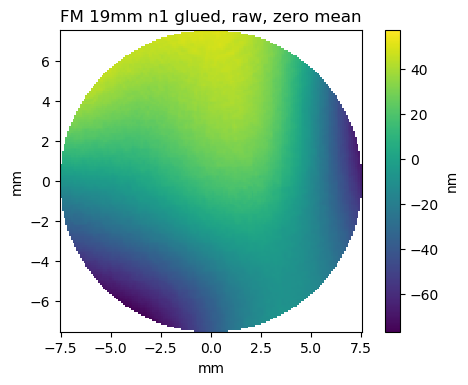

In [2]:
# initialize the data
tot_fm = 1
tot_step=4 # the last 2 step sets are bad news 
fits_folder = 'flat_mirrors/fixed_fits/'
raw_folder = 'flat_mirrors/2018_03_23/'

opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 0.019*u.m, #19*u.mm,
             'label': '19mm',
             'ring_width': 5,
             'kmid_ll': 100/u.m,# 0.1/u.mm,
             'khigh_ll': 1000/u.m}# 1/u.mm}

fm_loc = raw_folder+'flat_{0}_n1_100percent_afterglue.datx'.format(opt_parms['label'])
surf, mask, sp = dfx.open_datx(datx_file_loc=fm_loc, diam_ca100=opt_parms['diam_100CA'])
wavelen = sp['value'][sp['label'].index('wavelen')] # should be same for all steps
latres = sp['value'][sp['label'].index('latres')]
opt_parms['surf_units'] = sp['value'][sp['label'].index('surfunit')]
opt_parms['wavelen'] = wavelen
opt_parms['latres'] = latres
opt_parms['fm_num'] = 1
opt_parms['step_num'] = 0

# tighten up the matrix by removing empty rows and columns
surf, mask = dfx.mat_tight(surf, mask)

# apply a resize
surf, mask = dfx.reduce_ca(data=surf, mask=mask, old_ca=100, new_ca=opt_parms['ca']) 
opt_parms['diam_ca'] = mask.shape[0]*latres*u.pix#.to(u.mm/u.pix)*u.pix
raw_surf = copy.copy(surf)

# apply zero mean
active_pix = np.where(mask==1)
surf_mean = np.mean(surf[active_pix])
surf_zmean = surf - surf_mean

surf_zmean_nm = surf_zmean.to(u.nm)
data1_sn = dfx.sn_map(surface=surf_zmean_nm.value, mask=mask)
vmin = np.amin(surf_zmean_nm.value)
vmax = np.amax(surf_zmean_nm.value)
dfx.show_image(data=data1_sn,
              data_unit = surf_zmean_nm.unit,
              pixscale=(latres*u.pix).to(u.mm),
              fig_title='FM {0} n1 glued, raw, zero mean'.format(opt_parms['label']),
              cbar_lim=[vmin, vmax])

In [3]:
# convert to phase
wavenum = wavelen.to(surf.unit)/(2*np.pi*u.radian)
surf_phase = surf_zmean/wavenum # in phase units

# apply PTT removal
n_ptt = 3
n_max = 11
zm, zprj = zern.calc_zernike_proj(data=surf_phase, nterms=n_max, wavelength=wavelen, mask_full=mask)
zern_map = np.zeros((n_max, mask.shape[0], mask.shape[1]))
zern_prj = np.zeros((n_max))
for j in range(0, n_max):
    # calculate the Zernike
    z_mode = zern.calc_zernike_phase(j_index=j+1, ap_diam=mask.shape[0])*mask
    zern_map[j] = z_mode.value
    
    # vectorize the data to only the regions that matter
    z_vec = z_mode[mask==True] # automatic vectorization
    data_active = surf_phase[mask==True] # automatic vectorization
    
    # dot product ratio
    z_num = np.dot(data_active.value, z_vec.value)
    z_den = np.dot(z_vec.value, z_vec.value)
    zern_prj[j] = z_num/z_den # unitless ratio
    
    # apply correction
    surf_phase = (surf_phase - (zern_prj[j]*z_mode))*mask*1 # apply to 2D matrix
    
    # save PTT data for comparison
    if j==(n_ptt-1):
        surf_ptt = copy.copy(surf_phase)

# convert back to surface units        
surf_z11 = (surf_phase * wavenum).to(u.nm)
surf_ptt = surf_ptt * wavenum

print(zern_prj)

[ 0.         -0.02470482 -0.23286945 -0.09478694  0.10948048 -0.0750685
  0.01508946 -0.04225744  0.01233921 -0.06822031  0.0101416 ]


In [5]:
glue_dict = {'zern_glue': zern_prj}
import pickle
filename='/home/jhen/XWCL/code/MagAOX/PSD/zygo_data/zern_glue_19mm.pickle'
with open(filename,'wb') as glue_zernike_file:
    pickle.dump(glue_dict, glue_zernike_file, protocol=4)

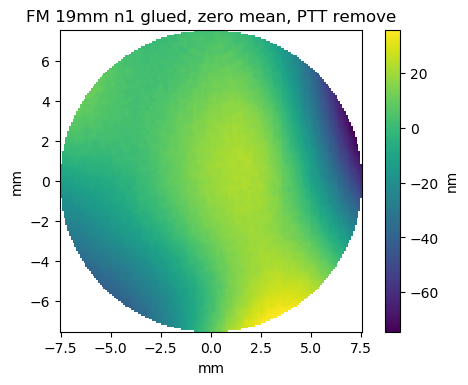

In [6]:
# show surface
surf_ptt_nm = surf_ptt.to(u.nm)
vmin = np.amin(surf_ptt_nm.value)
vmax = np.amax(surf_ptt_nm.value)
dfx.show_image(data=dfx.sn_map(surface=surf_ptt_nm.value, mask=mask),
              data_unit = surf_ptt_nm.unit,
              pixscale=(latres*u.pix).to(u.mm),
              fig_title='FM {0} n1 glued, zero mean, PTT remove'.format(opt_parms['label']),
              cbar_lim=[vmin, vmax])

In [25]:
# write surface to FITS file
header = fits.Header()
header['wavelen'] = (opt_parms['wavelen'].value,
                     'Zygo wavelength [{0}]'.format(opt_parms['wavelen'].unit))
header['latres'] = (opt_parms['latres'].value,
                    'Lateral resolution [{0}]'.format(opt_parms['latres'].unit))
header['surfunit'] = (str(surf_ptt.unit),
                      'Surface Units')
header['diam_100'] = (opt_parms['diam_100CA'].value,
                      'Full optic diameter at 100% CA [{0}]'.format(opt_parms['diam_100CA'].unit))
header['diam_ca'] = (opt_parms['diam_ca'].value, 
                     'Data diameter at clear aperture [{0}]'.format(opt_parms['diam_ca'].unit))
header['clear_ap'] = (opt_parms['ca'], 
                      'Clear aperture [percent]')

surf_name = 'flat_{0}_n{1}_{2}CA_glue'.format(opt_parms['label'], opt_parms['fm_num'], opt_parms['ca'])
fits.writeto(fits_folder+surf_name+'_mask.fits', mask*1.0, header, overwrite=True)

header['COMMENT'] = 'Surface has PTT Zernikes removed'
fits.writeto(fits_folder+surf_name+'_surf.fits', surf_ptt.value, header, overwrite=True)

In [7]:
%%time
# calculate the PSD using the FT method
fmg = psd.surfPSD(surf_name='FM_{0}_n1_glue'.format(opt_parms['label']))
fmg.load_surf(data=surf_ptt, wavelen=opt_parms['wavelen'], latres=opt_parms['latres'])
fmg.load_mask(mask=mask*1) # force from boolean to integer
fmg.calc_psd(oversamp=opt_parms['ovs'])
print('PSD calculated, doing radial analysis')
fmg.calc_psd_radial(ring_width=opt_parms['ring_width'], kmin=fmg.k_min)

PSD calculated, doing radial analysis
CPU times: user 3min 25s, sys: 1min 12s, total: 4min 38s
Wall time: 4min 38s


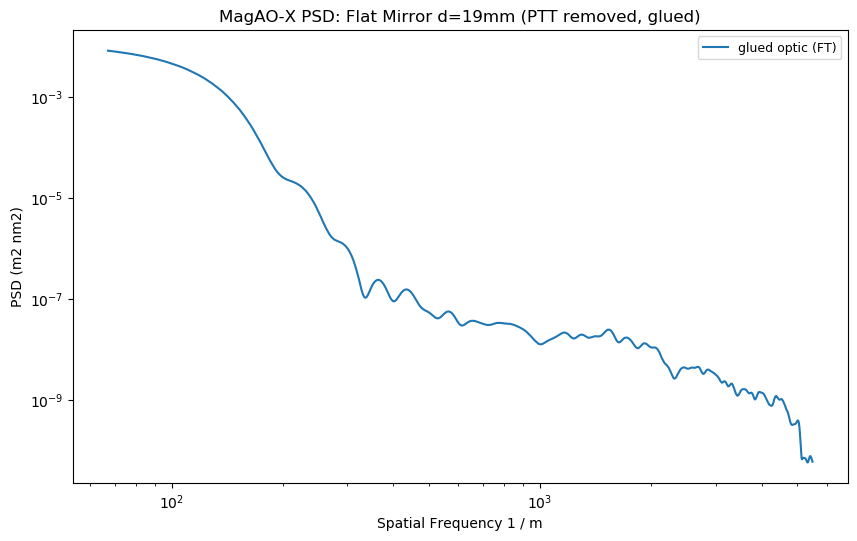

In [13]:
plt.figure(figsize=[10,6], dpi=100)
plt.loglog(fmg.k_radial.value, fmg.psd_radial_cal.value, label='glued optic (FT)')
#plt.ylim(top=1e5, bottom=1e-5)
plt.xlabel('Spatial Frequency {0}'.format(fmg.k_radial.unit))
plt.ylabel('PSD ({0})'.format(fmg.psd_radial_cal.unit))
plt.title('MagAO-X PSD: Flat Mirror d={0} (PTT removed, glued)'.format(opt_parms['label']))
plt.legend(prop={'size':9})#,loc='center left', bbox_to_anchor=(1, 0.5))